# 序列预测

---

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import init

## 已知
1949年到1960年每一个月的飞机客流量

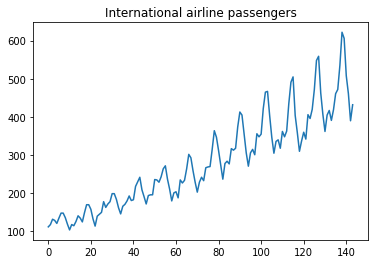

In [2]:
# 获取输入数据，并可视化

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

data = pd.read_csv('data.csv', usecols=[1])
plt.title('International airline passengers')
plt.plot(data)
plt.show()

---
## 目标
使用前三个月的客流量预测整年的飞机客流量。

以1949年到1958年的数据作为训练集， 1959和1960年的数据用作测试集。
## 方法
1. 模型使用某三个月的数据作为输入，获得第四个月的客流量
2. 然后使用两个月的流量+第四个月的流量，预测第5个月的客流量
3. 以此类推获得整年的客流量

## 比较
创建三个模型进行结果比较 : `FC`, `RNN`, `LSTM`, `GRU1`, `GRU2`

`GRU2`比`GRU1`多一般的状态数

分别从预测准确性，训练时间两方面分析。

---
**以下部分为数据预处理的代码，会在其他几个模型中动态生成\*.py文件并引用**

In [3]:
# 定义numpy转化为Tensor的函数
toTs = lambda x : torch.from_numpy(x)

# 定义检测cuda的函数
cudAvl = lambda x : x.cuda() if torch.cuda.is_available() else x

In [4]:
# 数据预处理
data = data.dropna()
dataSet = data.values
dataSet = dataSet.astype('float32')
print('dataSet shape :\t', dataSet.shape)


# 将数据分为训练集和测试集
train = dataSet[:12*10]
real = dataSet[12*10:]
print('train data shape :', train.shape)
print('real data shape :', real.shape)

dataSet shape :	 (144, 1)
train data shape : (120, 1)
real data shape : (24, 1)


In [5]:
input_size = 3

In [6]:
# 制造训练集
def create_dataset(dataset, look_back) :
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)) :
        x = dataset[i - look_back: i]
        y = dataset[i]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, input_size)
print(trainX.shape, trainY.shape)

(117, 3, 1) (117, 1)


In [7]:
# 制造测试集, 选择real数据中第1, 7, 11开始的三个月份作为测试集

startMonth = [0, 6, 10] # 下标比真实月份少1
test, result = [], []
for i in startMonth :
    test.append(real[i:i+3, :])
    result.append(real[i:i+12, :])
test = np.array(test)
result = np.array(result).reshape(-1, 12)
print(test.shape, result.shape)


(3, 3, 1) (3, 12)
